# Week 2

Running this notebook will generate all samples that were included in the best entries folder. There are also some additional intermediate results for the male speech sample.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import mean_squared_error
from os import getcwd

In [2]:
# edit this to current directory if required
cwd = getcwd()+'/'
cwd

'/Users/joejohnson/Documents/sf1-data-analysis/jj485_sf1_week2/'

In [3]:
samplerate, piano_c = wavfile.read(cwd+'resources/week2/piano/piano_clean.wav')
piano_c = piano_c.astype(np.float64)

In [4]:
# 1 channel piano recording
N = piano_c.shape[0]
N

16384

In [5]:
Power = np.sqrt(np.mean(np.power(piano_c.astype(np.int32), 2)))
noisep = 250
Power

682.3702366696383

In [6]:
# generate noise
noise = np.random.normal(scale=np.sqrt(noisep), size=N)
np.mean(np.square(noise))

247.9775298158108

In [7]:
piano_n = piano_c.astype(np.float64) + noise
piano_n.dtype

dtype('float64')

In [8]:
wavfile.write(cwd+'resources/week2/piano/piano_noisy.wav', samplerate, piano_n.astype(np.int16))

### Short Time Fourier Transform

In [9]:
def wiener_gains(stft_data, noise_power, f, exponen, alph):
    # length of dft and number of bins
    nfs = stft_data.shape[0]
    nbins = stft_data.shape[1]
    # estimate of Power Spectrum
    Sy = np.square(np.abs(stft_data))
    # initialise gain matrix with the same shape as the stft data
    gains = np.zeros(stft_data.shape)
    # iterate over bins
    for i in range(nbins):
        # dft of the ith bin
        current_frame = Sy[:,i]
        # apply wiener rule, including maxing with zero
        gains[:,i] = np.maximum((current_frame - alph*noise_power/np.power(f, exponen)) / (current_frame), np.zeros(nfs))
    return gains

def noise_reduction(audio, noise_estimate, fsamp, M, red_func, ov, window_t='hanning', expon=0, filter_spec=False, delt=0.5, alpha=1):
    # check NOLA and COLA conditions
    if (signal.check_COLA(window_t, M, ov) & signal.check_NOLA(window_t, M, ov)):
        # take stft of the audio signal
        freqs, _, Zxx = signal.stft(audio, fs=fsamp, window=window_t, nperseg=M, noverlap=ov)
        norm_freqs = 2*np.pi * freqs / audio.shape[0]
        # calculate gain matrix according to our choice of red_func
        gains = red_func(Zxx, noise_estimate, norm_freqs, expon, alpha)
        
        if filter_spec:
            gains = lpf(gains, delt)

        # take inverse stft of gain data product to extract processed data
        _, clean = signal.istft(Zxx*gains, fs=fsamp, window=window_t, nperseg=M, noverlap=ov)
        return clean
    else:
        raise Exception("Window violates at least one of the NOLA or COLA conditions")

In [10]:
data_clean = noise_reduction(piano_n, noisep, samplerate, 256, wiener_gains, ov=256/2)

In [11]:
wavfile.write(cwd+'resources/week2/piano/piano_cleaned.wav', samplerate, data_clean.astype(np.int16))

In [12]:
mean_squared_error(piano_c, piano_n), mean_squared_error(piano_c, data_clean)

(247.9775298158108, 3105.2704028563267)

### Noise estimation

In [13]:
male_s_rate, male_s = wavfile.read(cwd+"resources/week2/Noisy Audio/male/male_soft/male_speech_noisy_soft.wav")
male_s = male_s[:130000].astype(np.float64) # drop last sample for easier windowing
M_male_s = 250
N_male_s = male_s.shape[0]

In [14]:
male_s_noise = male_s[0:int(male_s_rate*1.713)]
wavfile.write(cwd+"resources/week2/Noisy Audio/male/male_soft/male_soft_noise.wav", male_s_rate, male_s_noise.astype(np.int16))

In [15]:
def estimate_noise_est(noise_samp):
    # mean square amplitude
    return np.mean(np.square(noise_samp))

In [16]:
male_s_noise_p = estimate_noise_est(male_s_noise)
male_s_noise_p

6850.320344424986

In [17]:
male_s_cleaned = noise_reduction(male_s, male_s_noise_p, male_s_rate, M_male_s, wiener_gains, ov=M_male_s/2)

In [18]:
wavfile.write(cwd+'resources/week2/Noisy Audio/male/male_soft/male_soft_cleaned_est.wav', male_s_rate, male_s_cleaned.astype(np.int16))

# More complex techniques
### Low pass filter noise estimation

In [19]:
def estimate_noise_lpf(noise_samp, gam):
    # initialise average square noise value
    ave_n = 0
    gam_com = 1-gam
    # first order low pass filter
    for i in range(noise_samp.shape[0]):
        ave_n = gam * ave_n + gam_com * np.square(noise_samp[i])
        
    return ave_n

In [20]:
Noise_ave_sq = estimate_noise_lpf(male_s_noise, 0.85)

In [21]:
Noise_ave_sq

689.8945216935393

In [22]:
male_s_cleaned_lpf = noise_reduction(male_s, Noise_ave_sq, male_s_rate, M_male_s, wiener_gains, ov=M_male_s/2)
wavfile.write(cwd+'resources/week2/Noisy Audio/male/male_soft/male_soft_cleaned_lpf.wav', male_s_rate, male_s_cleaned_lpf.astype(np.int16))

### Low pass filter of processed spectrum

In [23]:
def lpf(stft_data, delta):
    nfs = stft_data.shape[0]
    nbins = stft_data.shape[1]
    abs_data = np.abs(stft_data)
    for i in range(nfs):
        current_frame = abs_data[i,:]
        # lpf each frequency spectrum
        for j in range(1, nbins):
            current_frame[j] = delta*current_frame[j-1] + (1-delta)*current_frame[j]
        abs_data[i,:] = current_frame
    return abs_data

In [24]:
male_s_cleaned_filtered = noise_reduction(male_s, Noise_ave_sq, male_s_rate, M_male_s, wiener_gains, ov=M_male_s/2, filter_spec=True, delt=0.9)
wavfile.write(cwd+'resources/week2/Noisy Audio/male/male_soft/male_soft_cleaned_lpf_filtered.wav', male_s_rate, male_s_cleaned_filtered.astype(np.int16))

### Noise oversubtraction

In [25]:
#def floor_gains(stft_data, noise_power, alpha, beta):
#    nfs = stft_data.shape[0]
#    nbins = stft_data.shape[1]
#    abs_data = np.square(np.abs(stft_data))
#    gains = np.zeros(stft_data.shape)
#    # bin number i
#    for i in range(nbins):
#        current_frame = abs_data[:,i]
#        gains[:,i] = np.maximum(beta*current_frame, (current_frame-alpha*(noise_power)))/current_frame
#    return gains"""

In [26]:
#dipper_gains_floor = floor_gains(Zdipper, Noise_ave_sq_dip, 2, 0.01)
#_, dipper_cleaned_floor = signal.istft(Zdipper*dipper_gains_floor, fs=dipperrate, window='hanning', nperseg=M_dipper, noverlap=None)

In [27]:
#wavfile.write(cwd+'resources/week2/Noisy Audio/dipper/dipper_cleaned_floor.wav', dipperrate, dipper_cleaned_floor.astype(np.int16))

### Coloured noise

In [28]:
male_c_rate, male_c = wavfile.read(cwd+"resources/week2/Noisy Audio/male/male_col/male_speech_noisy_col.wav")
male_c = male_c[:130000].astype(np.float64) # drop last sample for easier windowing
M_male_c = 2048
N_male_c = male_c.shape[0]
N_male_c

130000

In [29]:
male_c_noise = male_c[0:int(male_c_rate*1.7)]
wavfile.write(cwd+"resources/week2/Noisy Audio/male/male_col/male_col_noise.wav", male_c_rate, male_c_noise.astype(np.int16))

In [30]:
wind = signal.windows.hann(M_male_c)
window_padded = np.pad(wind, (0, male_c_noise.shape[0]-M_male_c))
axis = np.fft.fftshift(np.fft.fftfreq(male_c_noise.shape[0]))

In [31]:
def fit_least_squares_1(noise_sample , w, range_low, range_high, M):
    # frequency axis
    axis = np.fft.fftshift(np.fft.fftfreq(noise_sample.shape[0]))
    # window the noise
    wind = signal.windows.hann(M)
    window_padded = np.pad(wind, (0, noise_sample.shape[0]-M))
    # find windowed noise specturm 
    ft = np.fft.fftshift((np.abs(np.fft.fft(noise_sample*window_padded))))
    # smooth the spectrum 
    Sn = np.convolve(ft, np.ones(w), 'same')/w
    # least squares solution on specified range
    A = np.sum(np.divide(Sn[range_low:range_high], np.abs(axis[range_low:range_high]))) / np.sum(np.divide(1, np.square(axis[range_low:range_high])))
    return A

def fit_least_squares_2(noise_sample , w, range_low, range_high, M):
    # frequency axis
    axis = np.fft.fftshift(np.fft.fftfreq(noise_sample.shape[0]))
    # window the noise
    wind = signal.windows.hann(M)
    window_padded = np.pad(wind, (0, noise_sample.shape[0]-M))
    # find windowed noise specturm 
    ft = np.fft.fftshift((np.abs(np.fft.fft(noise_sample*window_padded))))
    # smooth the spectrum 
    Sn = np.convolve(ft, np.ones(w), 'same')/w
    # least squares solution on specified range
    A = np.sum(np.divide(Sn[range_low:range_high], np.square(axis[range_low:range_high]))) / np.sum(np.divide(1, np.power(axis[range_low:range_high], 4)))
    return A

In [32]:
A = fit_least_squares_1(male_c_noise, 150, 15000, 24000, 2048)
A

108.82527476756488

In [33]:
B = fit_least_squares_2(male_c_noise, 150, 15000, 24000, 2048)
B

7.685713199554807

<IPython.core.display.Javascript object>


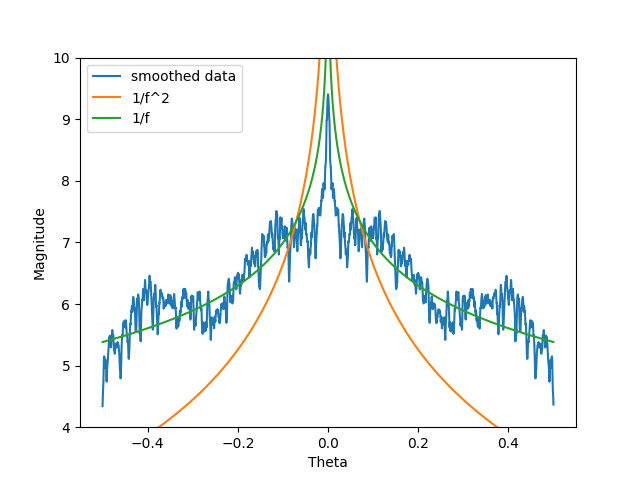

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [34]:
plt.figure()
ft = np.fft.fftshift((np.abs(np.fft.fft(male_c_noise*window_padded))))
w=150
Sn = np.convolve(ft, np.ones(w), 'same')/w
plt.plot(axis, np.log(Sn), label='smoothed data')
plt.plot(axis, np.log(np.abs(np.divide(B, axis**2))), label='1/f^2')
plt.plot(axis, np.log(np.abs(np.divide(A, axis))), label='1/f')
plt.xlabel('Theta')
plt.ylabel('Magnitude')
plt.ylim(4, 10)
plt.legend(loc='upper left')

In [35]:
male_c_cleaned = noise_reduction(male_c, A, male_c_rate, 150, wiener_gains, 150/2, expon=1, filter_spec=True, delt=0.9)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


In [36]:
wavfile.write(cwd+'resources/week2/Noisy Audio/male/male_col/male_col_cleaned.wav', male_c_rate, male_c_cleaned.astype(np.int16))

### Male speech with loud Noise

In [37]:
male_l_rate, male_l = wavfile.read(cwd+"resources/week2/Noisy Audio/male/male_loud/male_speech_noisy_loud.wav")
male_l = male_l[:130000].astype(np.float64) # drop last sample for easier windowing
M_male_l = 250
N_male_l = male_l.shape[0]

In [38]:
male_l_noise = male_l[0:int(male_l_rate*1.713)]
male_l_noise_squared = estimate_noise_lpf(male_l_noise, 0.85)
male_l_noise_squared

81667.9984477418

In [39]:
male_l_cleaned = noise_reduction(male_l, male_l_noise_squared, male_l_rate, 250, wiener_gains, 250/2, filter_spec=True, delt=0.85, alpha=1)


In [40]:
wavfile.write(cwd+'resources/week2/Noisy Audio/male/male_loud/male_loud_cleaned_lpf_filtered.wav', male_l_rate, male_l_cleaned.astype(np.int16))

### Female speech

#### Soft

In [41]:
female_s_rate, female_s = wavfile.read(cwd+"resources/week2/Noisy Audio/female/female_soft/female_speech_noisy_soft.wav")
female_s = female_s[:120000].astype(np.float64) # drop last sample for easier windowing
N_female_s = female_s.shape[0]
N_female_s

120000

In [42]:
female_s_noise = female_s[0:int(female_s_rate*0.40)]
female_s_noise_squared = estimate_noise_lpf(female_s_noise, 0.99)
female_s_noise_squared

1641.4094025228865

In [43]:
female_s_cleaned = noise_reduction(female_s, female_s_noise_squared, female_s_rate, 300, wiener_gains, 300/2, filter_spec=True, delt=0.9, alpha=1)

In [44]:
wavfile.write(cwd+'resources/week2/Noisy Audio/female/female_soft/female_soft_cleaned_lpf_filtered.wav', female_s_rate, female_s_cleaned.astype(np.int16))


### Loud

In [45]:
female_l_rate, female_l = wavfile.read(cwd+"resources/week2/Noisy Audio/female/female_loud/female_speech_noisy_loud.wav")
female_l = female_l[:120000].astype(np.float64) # drop last sample for easier windowing
N_female_l = female_l.shape[0]
N_female_l

120000

In [46]:
female_l_noise = female_l[0:int(female_l_rate*0.40)]
female_l_noise_squared = estimate_noise_lpf(female_l_noise, 0.99)
female_l_noise_squared

119574.18326111378

In [47]:
female_l_cleaned = noise_reduction(female_l, female_l_noise_squared, female_l_rate, 300, wiener_gains, 225, filter_spec=True, delt=0.8, alpha=1)


In [48]:
wavfile.write(cwd+'resources/week2/Noisy Audio/female/female_loud/female_loud_cleaned_lpf_filtered.wav', female_l_rate, female_l_cleaned.astype(np.int16))

#### Coloured

In [49]:
female_c_rate, female_c = wavfile.read(cwd+"resources/week2/Noisy Audio/female/female_col/female_speech_noisy_col.wav")
female_c = female_c[:120000].astype(np.float64) # drop last sample for easier windowing
M_female_c = 2048
N_female_c = female_c.shape[0]
N_female_c

120000

In [50]:
female_c_noise = female_c[0:int(female_c_rate*0.4)]
wavfile.write(cwd+"resources/week2/Noisy Audio/female/female_col/female_col_noise.wav", female_c_rate, female_c_noise.astype(np.int16))

In [51]:
wind_f = signal.windows.hann(M_female_c)
window_padded_f = np.pad(wind_f, (0, female_c_noise.shape[0]-M_female_c))
axisf = np.fft.fftshift(np.fft.fftfreq(female_c_noise.shape[0]))

In [52]:
Af = fit_least_squares_1(female_c_noise, 150, 4000, 6000, 2048)
Af

132.35460564760058

In [53]:
Bf = fit_least_squares_2(female_c_noise, 150, 4000, 6000, 2048)
Bf

23.772997817022905

<IPython.core.display.Javascript object>


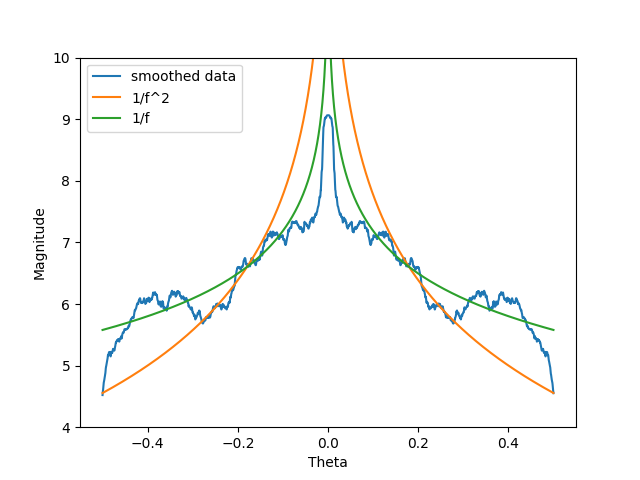

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [54]:
plt.figure()
ftf = np.fft.fftshift((np.abs(np.fft.fft(female_c_noise*window_padded_f))))
wf=150
Snf = np.convolve(ftf, np.ones(wf), 'same')/wf
plt.plot(axisf, np.log(Snf), label='smoothed data')
plt.plot(axisf, np.log(np.abs(np.divide(Bf, axisf**2))), label='1/f^2')
plt.plot(axisf, np.log(np.abs(np.divide(Af, axisf))), label='1/f')
plt.xlabel('Theta')
plt.ylabel('Magnitude')
plt.ylim(4, 10)
plt.legend(loc='upper left')

In [55]:
female_c_cleaned = noise_reduction(female_c, Af, female_c_rate, 300, wiener_gains, 300/2, expon=1, filter_spec=True, delt=0.85)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


In [56]:
wavfile.write(cwd+'resources/week2/Noisy Audio/female/female_col/female_col_cleaned.wav', female_c_rate, female_c_cleaned.astype(np.int16))

### Dipper

In [57]:
dipperrate, dipper = wavfile.read(cwd+'resources/week2/Noisy Audio/dipper/dipper.wav')
dipper = dipper.astype(np.int64)

In [58]:
dipper_noise = dipper[:int(0.5*dipperrate)]
dipper_noise_est = estimate_noise_lpf(dipper_noise, 0.6)
dipper_noise_est

243876.67700624975

In [59]:
dipper_cleaned = noise_reduction(dipper, dipper_noise_est, dipperrate, 400, wiener_gains, 300, filter_spec=True, delt=0.9, alpha=1)


In [60]:
wavfile.write(cwd+'resources/week2/Noisy Audio/dipper/dipper_cleaned.wav', dipperrate, dipper_cleaned.astype(np.int16))


### Fast piano noisy

In [61]:
fastrate, fast = wavfile.read(cwd+'resources/week2/Noisy Audio/fast_n/fast_n.wav')
fast = fast.astype(np.int64)

In [62]:
fast_noise = fast[int(11.4*fastrate):int(11.6*fastrate)]
fast_noise_est = estimate_noise_lpf(fast, 0.7)
fast_noise_est

array([2349.31894487, 2349.31894487])

In [63]:
fast_cleaned_left = noise_reduction(fast[:,0], fast_noise_est[0], fastrate, 250, wiener_gains, 125, filter_spec=True, delt=0.8, alpha=1)
fast_cleaned_right = noise_reduction(fast[:,1], fast_noise_est[1], fastrate, 250, wiener_gains, 125, filter_spec=True, delt=0.8, alpha=1)

In [64]:
fast_cleaned = np.vstack((fast_cleaned_left, fast_cleaned_right))
fast_cleaned = fast_cleaned.T

In [65]:
wavfile.write(cwd+'resources/week2/Noisy Audio/fast_n/fast_n_cleaned.wav', fastrate, fast_cleaned.astype(np.int16))